<a href="https://colab.research.google.com/github/ruhanaazam/gp_transfer/blob/main/MixedKernelTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!cd drive

In [3]:
!pip install gpytorch
!pip install botorch

In [4]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import gpytorch
from botorch.utils.transforms import normalize, standardize
import matplotlib.pyplot as plt

from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP, MixedSingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms import Standardize, Normalize
from botorch.utils.transforms import normalize, standardize
from botorch.fit import fit_gpytorch_mll

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def surfacePlot(model, title = "Your Function" ,n=900):
    '''
    Plots your (true or estimated) coheritability function.
    model: function that takes in two wavelength and outputs coh2 (estimate)
    n: n**2 is the number of points to plot the surface
    '''
    # Generate data for the plot
    x1 = torch.linspace(0, 1, n)
    x2 = torch.linspace(0, 1, n)
    X1, X2 = torch.meshgrid(x1, x2)
    X = torch.stack([X1.reshape((-1)),X2.reshape((-1))]).T

    Z = model(X.to(device)).cpu().detach().numpy()

    # Create a contour plot
    plt.contourf(X1, X2, Z.reshape(n, n), cmap='viridis')
    plt.colorbar(label='Function Value')

    #plot top 1%
    #threshold = np.percentile(Z, 99)
    #threshold = torch.kthvalue(Z.flatten(), int(0.99 * n * n)).values
    #plt.contour(X1, X2, Z.reshape(n, n), levels=[threshold], colors='red', linewidths=2)

    # Add labels and title
    plt.xlabel('Wavelength 1')
    plt.ylabel('Wavelength 2')
    plt.title(title)

    # Show the plot
    plt.show()
    return

In [6]:
def getTaskID(trait, crop="Sorghum"):
    assert crop == "Sorghum", "Does not handles ids for from that are not Sorghum yet."
    ids = {"narea": 1, "sla": 2, "pn": 3, "ps": 4}
    return ids[trait]

In [7]:
def loadTasks(tasks):
    taskData = []
    for trait in tasks:
        #read raw task file
        data = pd.read_csv(f"/content/drive/My Drive/Colab Notebooks/Transfer_Coh2/data/{trait}_coh2.csv")
        data = torch.tensor(data.values)

        #format data for supervised training, each row (taskid, wave1, wave2, coh2)
        n = torch.ones(data.shape[0], dtype=torch.float32)
        col_index =  torch.arange(data.shape[0], dtype=torch.float32)
        col_index = torch.outer(n, col_index)
        row_index = col_index.T

        #stack wave1, wave2 and coh2 tensors together
        task_ids = torch.ones(data.shape) * getTaskID(trait)
        flat_data = torch.stack([task_ids.flatten(), col_index.flatten(), row_index.flatten(), data.flatten()])
        flat_data = flat_data.T

        #remove all rows with nans
        nan_mask = torch.isnan(flat_data)
        nan_in_rows = torch.any(nan_mask, dim=1)
        clean = flat_data[~nan_in_rows]

        taskData.append(clean)

    #combine all tasks
    all_tasks = torch.cat(taskData)
    return all_tasks[:, :3], all_tasks[:, -1]

In [8]:
#Load data (by tasks)
X, Y = loadTasks(["narea", "sla", "pn", "ps"])

#Split into train and validation sets
seed = 1234
split = 0.85
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=split, random_state=seed)

# Convert NumPy arrays to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float64)
y_train = torch.tensor(y_train, dtype=torch.float64)
x_test = torch.tensor(x_test, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64)

<ipython-input-8-e16cc57aed88>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float64)
<ipython-input-8-e16cc57aed88>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float64)
<ipython-input-8-e16cc57aed88>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float64)
<ipython-input-8-e16cc57aed88>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

In [10]:
#small sanity check run
N = 100
d_xtrain = x_train[:N,0].reshape(-1,1) #discrete part
c_xtrain = normalize(x_train[:N, 1:], torch.tensor([[0,0],[2150,2150]])) #continous part
x_train_normalized = torch.cat([c_xtrain, d_xtrain], dim=1)
y_train_standardized = standardize(y_train[:N]).reshape(-1,1)

#model = SingleTaskGP(c_xtrain, y_train.reshape(-1,1))
model = MixedSingleTaskGP(x_train_normalized, y_train_standardized, cat_dims=[-1])

# Use Exact Marginal Log Likelihood as the loss
mll = ExactMarginalLogLikelihood(model.likelihood, model)

# Fit the model
fit_gpytorch_mll(mll, )

#get gaussian likelihood then it has object noise
#refer: https://docs.gpytorch.ai/en/stable/likelihoods.html
print(f"noise: {model.likelihood.noise.item()}")

#Get the lengthscale
#kernel = model.covar_module.base_kernel
#print(f"lengthscale: {kernel.lengthscale.detach()}")
print(model.covar_module)

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


noise: 9.999999974752427e-07
AdditiveKernel(
  (kernels): ModuleList(
    (0): ScaleKernel(
      (base_kernel): AdditiveKernel(
        (kernels): ModuleList(
          (0): MaternKernel(
            (raw_lengthscale_constraint): GreaterThan(1.000E-04)
          )
          (1): ScaleKernel(
            (base_kernel): CategoricalKernel(
              (raw_lengthscale_constraint): GreaterThan(1.000E-06)
            )
            (raw_outputscale_constraint): Positive()
          )
        )
      )
      (raw_outputscale_constraint): Positive()
    )
    (1): ScaleKernel(
      (base_kernel): ProductKernel(
        (kernels): ModuleList(
          (0): MaternKernel(
            (raw_lengthscale_constraint): GreaterThan(1.000E-04)
          )
          (1): CategoricalKernel(
            (raw_lengthscale_constraint): GreaterThan(1.000E-06)
          )
        )
      )
      (raw_outputscale_constraint): Positive()
    )
  )
)


In [11]:
#train SingleTaskGP
results = {"val_loss":[],
           "train_loss": []}

x_test_normalize = normalize(x_test[:1000, 1:], torch.tensor([[0,0],[2150,2150]]))
y_test_standardized = standardize(y_test[:1000]).reshape(-1,1)
option_n = [i for i in range(500, 3500, 500)]

for N in option_n:
  d_xtrain = x_train[:N,0].reshape(-1,1) #discrete part
  c_xtrain = normalize(x_train[:N, 1:], torch.tensor([[0,0],[2150,2150]])) #continous part
  x_train_normalized = torch.cat([c_xtrain, d_xtrain], dim=1)
  y_train_standardized = standardize(y_train[:N]).reshape(-1,1)

  model = SingleTaskGP(c_xtrain, y_train_standardized)
  #model = MixedSingleTaskGP(x_train_normalized, y_train_standardized, cat_dims=[-1])

  # Use Exact Marginal Log Likelihood as the loss
  mll = ExactMarginalLogLikelihood(model.likelihood, model)

  # Fit the model
  fit_gpytorch_mll(mll, )

  #get gaussian likelihood then it has object noise
  #refer: https://docs.gpytorch.ai/en/stable/likelihoods.html
  #print(f"noise: {model.likelihood.noise.item()}")

  #Get the lengthscale
  #kernel = model.covar_module.base_kernel
  #print(f"lengthscale: {kernel.lengthscale.detach()}")
  #print(model.covar_module)

  #save the losses
  y_hat = model.posterior(x_test_normalize).mean
  val_loss = torch.mean((y_test_standardized - y_hat)**2).item()
  results["val_loss"].append(val_loss)

  y_hat = model.posterior(c_xtrain).mean
  train_loss = torch.mean((y_train_standardized - y_hat)**2).item()
  results["train_loss"].append(train_loss)

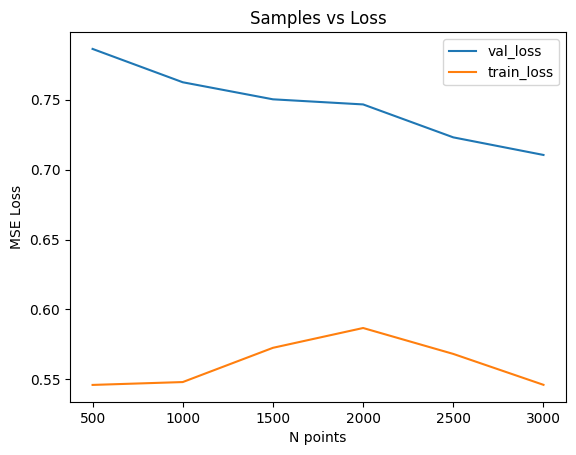

In [12]:
#plot training and validation loss
# Create a line plot
plt.plot(option_n, results["val_loss"], label = "val_loss")
plt.plot(option_n, results["train_loss"], label = "train_loss")

# Add labels and title
plt.xlabel('N points')
plt.ylabel('MSE Loss')
plt.title('Samples vs Loss')
plt.legend()

# Show the plot
plt.show()

In [16]:
#train MultiTaskGP
results = {"val_loss":[],
           "train_loss": []}

d_xtest = x_test[:1000,0].reshape(-1,1) #discrete part
c_xtest = normalize(x_test[:1000, 1:], torch.tensor([[0,0],[2150,2150]])) #continous part
x_test_normalized = torch.cat([c_xtest, d_xtest], dim=1)
y_test_standardized = standardize(y_test[:1000]).reshape(-1,1)

for N in option_n:
  d_xtrain = x_train[:N,0].reshape(-1,1) #discrete part
  c_xtrain = normalize(x_train[:N, 1:], torch.tensor([[0,0],[2150,2150]])) #continous part
  x_train_normalized = torch.cat([c_xtrain, d_xtrain], dim=1)
  y_train_standardized = standardize(y_train[:N]).reshape(-1,1)

  #model = SingleTaskGP(c_xtrain, y_train_standardized)
  model = MixedSingleTaskGP(x_train_normalized, y_train_standardized, cat_dims=[-1])

  # Use Exact Marginal Log Likelihood as the loss
  mll = ExactMarginalLogLikelihood(model.likelihood, model)

  # Fit the model
  fit_gpytorch_mll(mll, )

  #get gaussian likelihood then it has object noise
  #refer: https://docs.gpytorch.ai/en/stable/likelihoods.html
  #print(f"noise: {model.likelihood.noise.item()}")

  #Get the lengthscale
  #kernel = model.covar_module.base_kernel
  #print(f"lengthscale: {kernel.lengthscale.detach()}")
  #print(model.covar_module)

  #save the losses
  y_hat = model.posterior(x_test_normalized).mean
  val_loss = torch.mean((y_test_standardized - y_hat)**2).item()
  results["val_loss"].append(val_loss)

  y_hat = model.posterior(x_train_normalized).mean
  train_loss = torch.mean((y_train_standardized - y_hat)**2).item()
  results["train_loss"].append(train_loss)

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputD

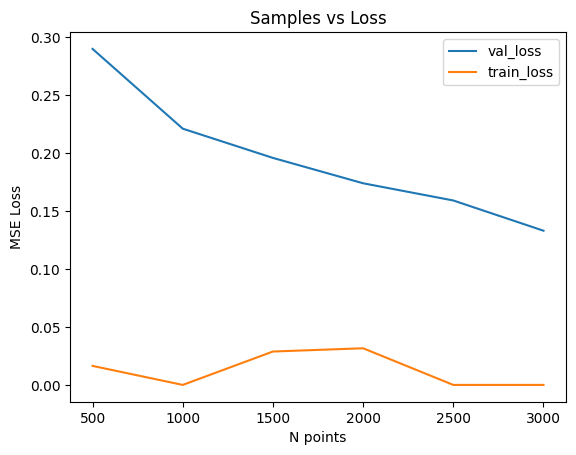

In [18]:
#plot training and validation loss
# Create a line plot
plt.plot(option_n, results["val_loss"], label = "val_loss")
plt.plot(option_n, results["train_loss"], label = "train_loss")

# Add labels and title
plt.xlabel('N points')
plt.ylabel('MSE Loss')
plt.title('Samples vs Loss')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# def getLossByTask(x_pred, y, model, results, label):
#   #must be botroch gp model
#   for task in ["narea", "sla", "pn", "ps"]:
#     id = getTaskID(task)
#     x_task = x_pred[x_pred[:, 0] == id]
#       y_task = y[x_pred[:, 0] == id]
#       y_hat = model.posterior(x_pred).mean
#       loss = torch.mean((y_hat - y_task)**2).item()

#       results[f"{task}_{label}"] = results.get(f"{task}_{label}", []) + [loss]
#     return results

In [1]:
task = "narea"

def modelWrapper(X):
  id = getTaskID(task)
  id_vector = id * torch.ones((X.shape[0],1))
  inp = torch.cat([X, id_vector], dim=1)
  return model.posterior(inp).mean

surfacePlot(modelWrapper, title=f"GP for task {task}, {len(x_train)} points", n=100)

NameError: name 'surfacePlot' is not defined

In [ ]:
task = "sla"

def modelWrapper(X):
  id = getTaskID(task)
  id_vector = id * torch.ones((X.shape[0],1))
  inp = torch.cat([X, id_vector], dim=1)
  return model.posterior(inp).mean

surfacePlot(modelWrapper, title=f"GP for task {task}, {len(x_train)} points", n=100)

In [ ]:
task = "pn"

def modelWrapper(X):
  id = getTaskID(task)
  id_vector = id * torch.ones((X.shape[0],1))
  inp = torch.cat([X, id_vector], dim=1)
  return model.posterior(inp).mean

surfacePlot(modelWrapper, title=f"GP for task {task}, {len(x_train)} points", n=100)

In [ ]:
task = "ps"

def modelWrapper(X):
  id = getTaskID(task)
  id_vector = id * torch.ones((X.shape[0],1))
  inp = torch.cat([X, id_vector], dim=1)
  return model.posterior(inp).mean

surfacePlot(modelWrapper, title=f"GP for task {task}, {len(x_train)} points", n=100)